In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Загрузка и предобработка данных

#### Словарь показателей, что содержится в выборке

In [2]:
# Импорт названий листов с данными
sheets = pd.read_csv('./data/sheets.txt', header=None).values.T[0].tolist()

# Импорт названий столбцов на соответствующих листах
sheets_columns = pd.read_csv('./data/sheets columns.txt', header=None, sep='\t').values

# Словарь-  лист: названия столбцов на листе
sname = dict((sheet,values.tolist()) for sheet,values in zip(sheets,sheets_columns))

#### Данные

In [3]:
# Информация об отчетах
earns = pd.read_csv('./data/earns.csv', low_memory=False)

# Логарифмические доходности
edata_before_adj_logret = pd.read_csv('./data/edata_before_adj_logret.csv', index_col=None, header=None).values
edata_after_adj_logret = pd.read_csv('./data/edata_after_adj_logret.csv', index_col=None, header=None).values
market_before_logret = pd.read_csv('./data/market_before_logret.csv', index_col=None, header=None).values
market_after_logret = pd.read_csv('./data/market_after_logret.csv', index_col=None, header=None).values

# Вектор бет
beta_ = pd.read_csv('./data/beta_before_adj.csv', index_col=None, header=None, skip_blank_lines=False).values

# Abnormal return 
edata_before_abn = edata_before_adj_logret - market_before_logret*beta_
edata_after_abn = edata_after_adj_logret - market_after_logret*beta_

# Рыночная капитализация компании
mcap_before = pd.read_csv('./data/mcap_before.csv', index_col=None, header=None, skip_blank_lines =False)
mcap_before.columns = ['mcap']

#### Доходности для учета

In [4]:
days_before = 10
days_after = 10+1

data_before_abn = pd.DataFrame(edata_before_abn[:,-days_before:], columns=['abn_b'+str(s) for s in range(days_before,0,-1)])
data_before_adj_logret = pd.DataFrame(edata_before_adj_logret[:,-days_before:], columns=['logret_b'+str(s) for s in range(days_before,0,-1)])

data_after_abn = pd.DataFrame(edata_after_abn[:,:days_after], columns=['abn_a'+str(s) for s in range(0,days_after)])
data_after_adj_logret = pd.DataFrame(edata_after_adj_logret[:,:days_after], columns=['logret_a'+str(s) for s in range(0, days_after)])

# Предсказание зная будущий показатель

Расчет производится при предположении, что мы знаем каков выйдет ожидаемый показатель. Если он выходит выше ожидаемого, то прогнозируем положительную доходность в нулевой день, и отрицательную если показатель выходит ниже ожидаемого значения. Данный метод позволяет оценить насколько разница между вышедшим и ожидаемым показателем совпадает с направлением доходности в нулевой день.

Примечательно, что для компаний с рыночной капитализацией меньше медианной, accuracy будет выше, чем аналогичный прогноз для компаний с капитализацией выше медианной по выборке.

In [15]:
# Преаллокация с предсказанными значениями
pre_vals = pd.DataFrame(index = sname.keys(), columns=['mcap_below', 'mcap_above'])

# Доп фильтр по рыночной капитализации
mcap_filter_below = (np.log(mcap_before) < np.log(mcap_before).median()).values.reshape(-1)
mcap_filter_above = (np.log(mcap_before) >= np.log(mcap_before).median()).values.reshape(-1)

print('Количество компаний с капитализацией ниже медианного', sum(mcap_filter_below))

for sheet_name in list(sname.keys()):
    
    # Названия актуальных и фактических признаков
    act_value = [s for s in sname[sheet_name] if 'ActValue' in s][0]
    mean_value = [s for s in sname[sheet_name] if 'Mean' in s][0]
    
    # Предсказание
    y_pred = earns[act_value] - earns[mean_value]
    y_pred[y_pred>=0] = 1
    y_pred[y_pred<0] = 0
    
    # Фактическое значение
    y = data_after_adj_logret['logret_a0'].copy()
    y[y>=0] = 1
    y[y<0] = 0
    
    # Доп фильтр по рыночной капитализации
    y_pred_below = y_pred[mcap_filter_below].copy()
    y_below = y[mcap_filter_below].copy()
    
    y_pred_above = y_pred[mcap_filter_above].copy()
    y_above = y[mcap_filter_above].copy()
    
    # Удалить строки с неизвестными данными
    nullrows = (y_below.isnull()) | (y_pred_below.isnull())
    y_pred_below = y_pred_below[~nullrows]
    y_below = y_below[~nullrows]
    
    nullrows = (y_above.isnull()) | (y_pred_above.isnull())
    y_pred_above = y_pred_above[~nullrows]
    y_above = y_above[~nullrows]
    
    pre_vals.loc[sheet_name, 'mcap_below'] = accuracy_score(y_below.values, y_pred_below)
    pre_vals.loc[sheet_name, 'mcap_above'] = accuracy_score(y_above.values, y_pred_above)

# Вычесть accuracy из единицы, если прогноз должен быть зеркальный
#pre_vals[pre_vals<0.5] = 1-pre_vals

pre_vals = round(pre_vals*100,2)
pre_vals.to_csv('Simple Inside forecast with mcap')
pre_vals

Количество компаний с капитализацией ниже медианного 18913


,mcap_below,mcap_above
Revenue,57.2276,57.2777
Gross Profit Margin,57.088,54.4261
EBITDA,61.3731,59.2343
EBITDA Per Share,58.9587,57.0914
EBIT,61.172,59.3986
Operating Profit,60.8175,58.1382
Pre-Tax Profit,61.9947,59.3614
Pre-Tax Profit Reported,60.2494,57.0674
Net Income,63.1818,60.0186
Net Income Reported,60.9574,57.7408


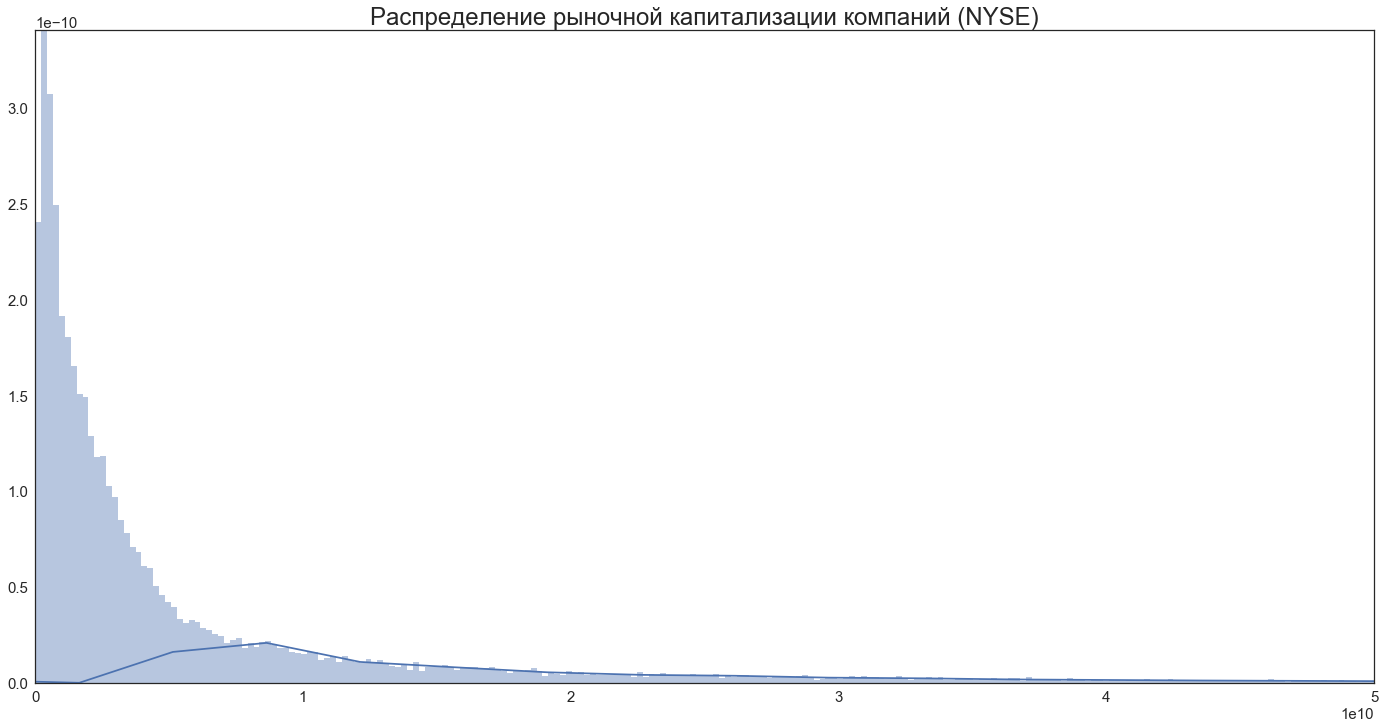

In [6]:
sns.set(style="white")
#sns.set_palette("RdBu")
#sns.set_color_codes("muted")
sns.set_context("notebook", font_scale = 1.5, rc = { "figure.figsize" : (24, 12), "axes.titlesize" : 18 })
dp = sns.distplot((mcap_before[~mcap_before.isnull().values]), bins=2000)

dp.axes.set_xlim(0, 5*1e10);
dp.axes.set_title('Распределение рыночной капитализации компаний (NYSE)', fontsize=24)

# Выборка: X - все признаки до события, y - направление доходности в нулевой день

Функция формирования выборки для прогноза направления доходности в нулевой день. 

Исходные данные содержат в себе оценки аналитиков о всех показателях (минимальная оценка, макс оценка, среднее, медианное значение, количество аналитиков, стандартное отклонение), логарифмические доходности до выхода события, избыточные доходности до выхода события. 

Параметр функции del_empty_vals позволяет удалить из выборки те признаки, которые содержать более del_empty_vals пропусков. По умолчанию = 5000. Остальные пропущенные значения устанавливаются равными нулю.

Целевая переменна y устанавливается в 1, если доходность в нулевой день больше или равна нулю, и в 0 - если доходность в нулевой день меньше 0.

In [7]:
def make_xy(del_empty_vals=5000):
    # Куммулятивные logret доходности и абнормал до события
    X = pd.concat([earns, mcap_before, data_before_abn, data_before_adj_logret], axis=1)

    # Предсказание направления гепа
    y = data_after_adj_logret['logret_a0'].copy()
    y[y>=0] = 1
    y[y<0] = 0

    # Удалить строки для которых неизвестна доходность
    X = X[~y.isnull()]
    y = y[~y.isnull()]

    # Убрать лишние столбцы с актуальным показателем, временем
    del_cols = ['Date', 'Ticker','date1', 'date2', 'event_date'] + \
        [s for s in X.columns if ('ActValue' in s) | ('ActSurprise' in s) | ('Date' in s)]
    X.drop(del_cols, axis=1, inplace=True)

    # Удалить признаки, где пропущенных данных больше заданного значения
    del_cols = X.columns[(X.isnull().sum() > del_empty_vals)]
    X.drop(del_cols, axis=1, inplace=True)

    # Заполнить пропуски нулями
    X = X.fillna(0)

    return X,y

# Выборка: X - все признаки до и после события, y - направление накопленной доходности после события за days_after

Функция формирования выборки для прогноза направления накопленной доходности за days_after_cum после выхода события. 

Исходные данные содержат в себе оценки аналитиков о всех показателях (минимальная оценка, макс оценка, среднее, медианное значение, количество аналитиков, стандартное отклонение), логарифмические доходности до выхода события, избыточные доходности до выхода события, а также актуальные значения вышедших показателей (актуальное значение, сюрприз по показателю в %) и величину доходности в нулевой день (логарифмическая и избыточная доходность).

Параметр функции del_empty_vals позволяет удалить из выборки те признаки, которые содержать более del_empty_vals пропусков. По умолчанию = 5000. Остальные пропущенные значения устанавливаются равными нулю.

Целевая переменна y устанавливается в 1, если накопленная доходность за days_after_cum дней после выхода события больше или равна нулю, и в 0 - если иначе. Доходность в нулевой день не входит в y, т.к. является признаком в X.

days_after_cum - за какое количество дней после выхода события просуммировать доходность. Доходность в день 0 исключается из суммирования в переменной y и находится как признак в переменной X

In [8]:
def make_xy2(days_after_cum, del_empty_vals=5000):
    # Количество дней для расчета накопленной доходности
    #days_logret = 10

    # Куммулятивные logret доходности и абнормал до события
    X = pd.concat([earns, mcap_before, data_before_abn, data_before_adj_logret, data_after_abn[:1], data_after_adj_logret[:1]], axis=1)

    # Зависимая переменная - куммулятивная доходность
    y = data_after_adj_logret.loc[:,'logret_a1':'logret_a'+str(days_after_cum)].cumsum(axis=1)['logret_a'+str(days_after_cum)]
    y[y>=0] = 1
    y[y<0] = 0

    # Удалить строки для которых неизвестна доходность
    notnans = ~y.isnull()
    X = X[notnans]
    y = y[notnans]

    # Убрать лишние столбцы
    del_cols = ['Date', 'Ticker','date1', 'date2', 'event_date'] + \
        [s for s in X.columns if ('Date' in s)]
    X.drop(del_cols, axis=1, inplace=True)

    # Удалить отдельные показатели, где много пропущенных данных
    # Количество пропусков больше которого удалить
    del_cols = X.columns[(X.isnull().sum()>del_empty_vals)]
    X.drop(del_cols, axis=1, inplace=True)

    X = X.fillna(0)
    
    return X,y

# Случайный лес. Определить функцию классификатора
Возвращает accuracy на тесте и важность признаков

X - выборка с признаками, y - целевая переменная
test_size - размер тестовой выборки

In [9]:
def forest_clf(X,y, test_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Инициализируем и обучаем классификатор
    rfc = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
    rfc.fit(X_train, y_train)

    # Предсказания на тесте
    y_pred = rfc.predict(X_test)
    
    # Софрмировать датафрейм с важностью признаков
    feature_imp = pd.DataFrame(rfc.feature_importances_, index = X.columns)
    
    return accuracy_score(y_test, y_pred), feature_imp

## Функция для отрисовки значимости признаков
При установке положительного числа num_to_plot отрисовывются первые по важности признаки, если отрицательно - последние.

In [10]:
def plot_importances(feature_imp, num_to_plot=10):
    
    # Отсортировать по убыванию значимости
    feature_imp = feature_imp.sort_values(0, ascending=False)
    
    if num_to_plot>0:
        imp_plot = feature_imp.iloc[:num_to_plot]
    elif num_to_plot<0:
        imp_plot = feature_imp.iloc[num_to_plot:]

    plt.figure(figsize=(15,6))
    ax = plt.axes()

    
    plt.bar(range(abs(num_to_plot)), imp_plot.values,
        color=([str(i/float(abs(num_to_plot)+1)) for i in range(abs(num_to_plot))])) 
    
    ticks = plt.xticks(range(abs(num_to_plot)), imp_plot.index)
    
    plt.title(u"Значимость признаков в предсказании направления доходности", fontsize=22)
    plt.xlim([-1, abs(num_to_plot)])
    plt.xticks(rotation=80);

    vals = ax.get_yticks()*100
    ax.set_yticklabels(['{:.1f}%'.format(x) for x in vals]);

## Предсказание до выхода события

Размерность выборки (37839, 63)
Доля правильных ответов (для всех компаний) 0.524775369979
Доля правильных ответов (капитализация выше медианного) 0.509249471459
Доля правильных ответов (капитализация ниже медианного) 0.531580338266


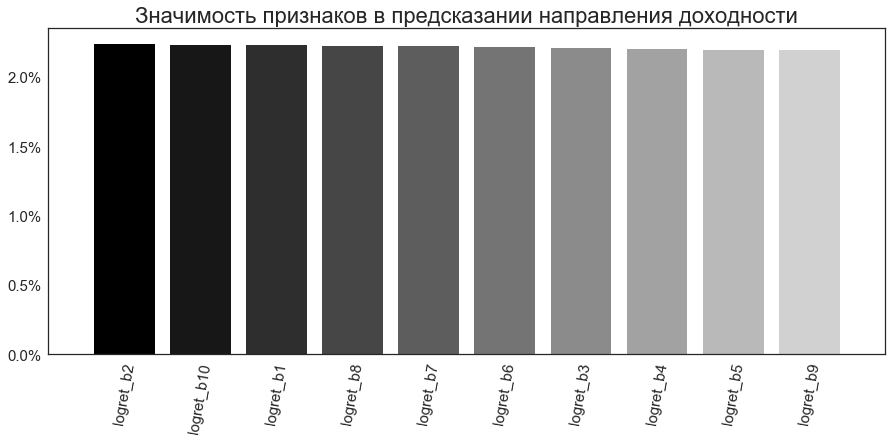

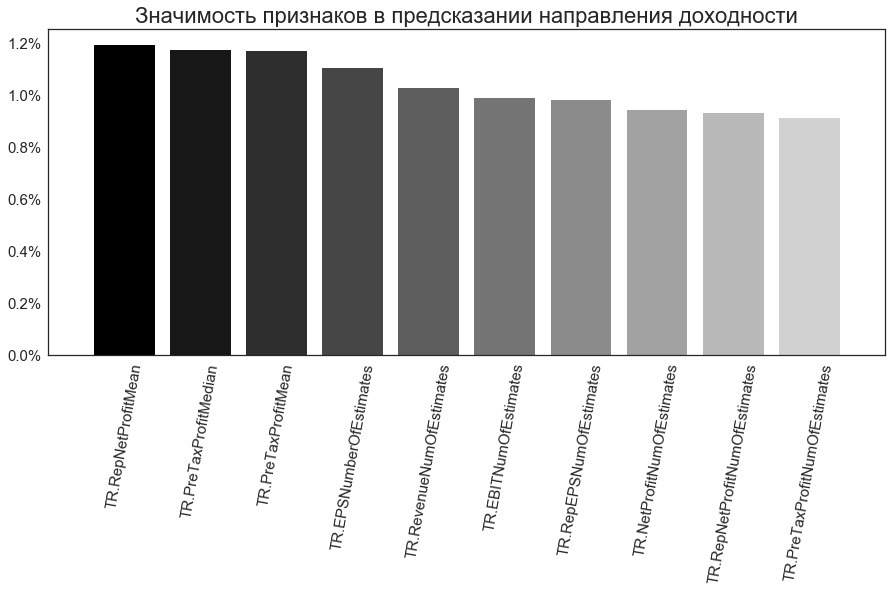

In [11]:
# Доля тестовой выборки
test_size = 0.4

# Сформировать выборку
X,y = make_xy(del_empty_vals=5000)
print('Размерность выборки', X.shape)

# Беги Forest, беги!
test_acc, feature_imp = forest_clf(X,y, test_size=test_size)
print('Доля правильных ответов (для всех компаний)', test_acc)

# Вариант для разных капитализаций
cap_above = X['mcap']>X['mcap'].median()
test_acc, _ = forest_clf(X[cap_above],y[cap_above], test_size=test_size)
print('Доля правильных ответов (капитализация выше медианного)', test_acc)

test_acc, _ = forest_clf(X[~cap_above],y[~cap_above], test_size=test_size)
print('Доля правильных ответов (капитализация ниже медианного)', test_acc)

# Отобразить важность признаков
plot_importances(feature_imp, 10)
plot_importances(feature_imp, -10)

## Предсказание после выхода события

In [12]:
# Количество дней для которых построить предсказание накопленной доходности
num_days_predict = 10

# Доля тестовой выборки
test_size = 0.4

# Количество пропущенных данных для удаления столбцов признака
del_empty_vals = 5000

# Для хранения результатов
results = pd.DataFrame(index=range(1,num_days_predict+1), columns=['all', 'mcap_above', 'mcap_below'])

# Фильтр по рыночной капитализации
X,_ = make_xy2(1,del_empty_vals=del_empty_vals)
cap_above = X['mcap']>X['mcap'].median()

print('Размерность выборки', X.shape)

for days_after_cum in range(1,num_days_predict+1):
    
    # Сформировать выборку
    X,y = make_xy2(days_after_cum,del_empty_vals=del_empty_vals)
    
    # Беги Forest, беги!
    results.loc[days_after_cum,'all'], feature_imp = forest_clf(X,y, test_size=test_size)
    results.loc[days_after_cum,'mcap_above'], feature_imp_above = forest_clf(X[cap_above],y[cap_above], test_size=test_size)
    results.loc[days_after_cum,'mcap_below'], feature_imp_below = forest_clf(X[~cap_above],y[~cap_above], test_size=test_size)
    
# Сохранить и показать результаты
results.to_csv('Предсказание накопленной доходности за разное колво дней после выхода события.csv')
results

Размерность выборки (38087, 69)


,all,mcap_above,mcap_below
1,0.539613,0.530717,0.551326
2,0.54854,0.531504,0.558283
3,0.545323,0.552245,0.549226
4,0.546045,0.53623,0.554739
5,0.540663,0.538593,0.544762
6,0.547096,0.548438,0.542531
7,0.550903,0.552376,0.548307
8,0.551756,0.554082,0.541481
9,0.553791,0.563796,0.551457
10,0.559304,0.566422,0.548307


### Важность признаков для последнего прогноза

In [13]:
# Сохранить важность признаков
pd.concat([feature_imp.sort_values(0, ascending=False).ix[:10],
           feature_imp_above.sort_values(0, ascending=False).ix[:10], 
           feature_imp_below.sort_values(0, ascending=False).ix[:10]
          ], axis=1).to_csv('feature importances first 10.csv', header=['all', 'above', 'below'])

pd.concat([feature_imp.sort_values(0, ascending=False).ix[-10:],
           feature_imp_above.sort_values(0, ascending=False).ix[-10:], 
           feature_imp_below.sort_values(0, ascending=False).ix[-10:]
          ], axis=1).to_csv('feature importances last 10.csv', header=['all', 'above', 'below'])

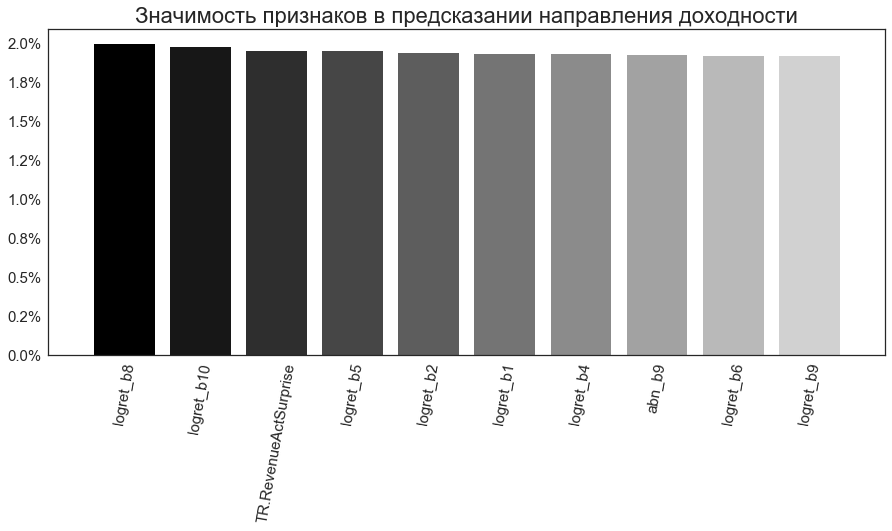

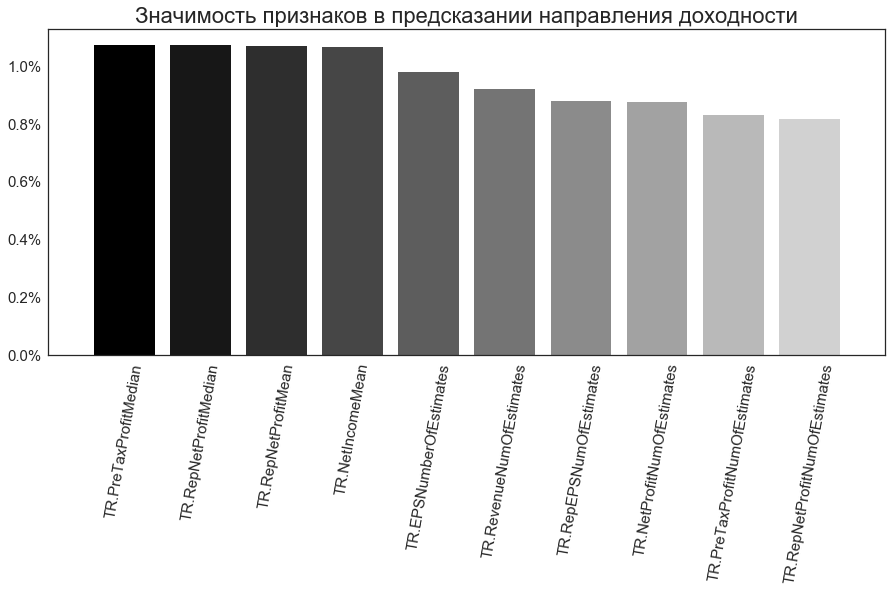

In [14]:
plot_importances(feature_imp, 10)
#plot_importances(feature_imp_above, 10)
#plot_importances(feature_imp_below, 10)

plot_importances(feature_imp, -10)
#plot_importances(feature_imp_above, -10)
#plot_importances(feature_imp_below, -10)